In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.special import erf

from absl import app, flags

from iflow.integration import integrator
from iflow.integration import couplings

tfd = tfp.distributions  # pylint: disable=invalid-name
tfb = tfp.bijectors  # pylint: disable=invalid-name
tf.keras.backend.set_floatx('float64')

In [2]:
def prepare_mother_list(filepath):
    file_to_open = open(filepath,"r")
    datastr = file_to_open.readlines()
    list_of_data_from_file = [line.split() for line in datastr]
    
    #convert str to float
    data=[]
    for ct, ele in enumerate(list_of_data_from_file):
        newele = [float(i) for i in list_of_data_from_file[ct]]
        data.append(newele[1:])
    data=np.array(data)
    
    #get rid of nan or zero
    mask=np.any(np.isnan(data)|np.equal(data,0),axis=1)
    data=data[~mask]
    list_by_minv=np.array(sorted(data,key=lambda particle: particle[0]))
    
    return list_by_minv

def prepare_data_train_signal(M,deltaM,list_by_minv):
    # pick a window
    listcp = np.copy(list_by_minv)
    listcp[:,0]=np.where(listcp[:,0]>(M+deltaM),0,listcp[:,0])
    listcp[:,0]=np.where(listcp[:,0]<(M-deltaM),0,listcp[:,0])
    mask = np.any (np.equal(listcp, 0), axis=1)
    sublist=listcp[~mask]
    
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    
    return data_train[:,1:5],sublist[:,0]

def prepare_data_train_bkg(list_by_minv):
    
    sublist=np.copy(list_by_minv)   
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    data_train = tf.where(data_train <1.0, data_train, 1.0-1e-16)
    return data_train[:,1:5]

def prepare_data_train(M,deltaM,list_by_minv):
    # pick a window
    listcp = np.copy(list_by_minv)
    listcp[:,0]=np.where(listcp[:,0]>(M+3*deltaM),0,listcp[:,0])
    listcp[:,0]=np.where(listcp[:,0]<(M-3*deltaM),0,listcp[:,0])
    #listcp[:,0]=np.where(listcp[:,0]>(M+deltaM),0,listcp[:,0])
    #listcp[:,0]=np.where(listcp[:,0]<(M-deltaM),0,listcp[:,0])
    mask = np.any (np.equal(listcp, 0), axis=1)
    daughter=listcp[~mask]
    listcp = np.copy(daughter)
    listcp[:,0]=np.where(listcp[:,0]>(M+deltaM),0,listcp[:,0])
    listcp[:,0]=np.where(listcp[:,0]<(M-deltaM),0,listcp[:,0])
    mask = np.any (np.equal(listcp, 0), axis=1)
    siglist=listcp[~mask]
    bkglist=daughter[mask] 
    
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train_sig=(siglist-minimum)*(1.0/(maximum-minimum))
    data_train_bkg=(bkglist-minimum)*(1.0/(maximum-minimum))
    data_train_sig = tf.where(data_train_sig > 1e-16, data_train_sig, data_train_sig+1e-16)
    data_train_bkg = tf.where(data_train_bkg > 1e-16, data_train_bkg, data_train_bkg+1e-16)
    data_train_sig = tf.where(data_train_sig <1.0, data_train_sig, 1.0-1e-16)
    data_train_bkg = tf.where(data_train_bkg <1.0, data_train_bkg, 1.0-1e-16)
    return data_train_bkg[:,0:5], data_train_sig[:,0:5], siglist[:,0]

In [3]:
def build(in_features, out_features, options):
    " Build the NN. """
    del options

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(32, activation='relu')(invals)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outputs = tf.keras.layers.Dense(out_features)(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

In [4]:
def mask_flip(mask):
    """ Interchange 0 <-> 1 in the mask. """
    return 1-mask


def binary_list(inval, length):
    """ Convert x into a binary list of length l. """
    return np.array([int(i) for i in np.binary_repr(inval, length)])


def binary_masks(ndims):
    """ Create binary masks for to account for symmetries. """
    n_masks = int(np.ceil(np.log2(ndims)))
    sub_masks = np.transpose(np.array(
        [binary_list(i, n_masks)
         for i in range(ndims)]))[::-1]
    flip_masks = mask_flip(sub_masks)

    # Combine masks
    masks = np.empty((2*n_masks, ndims))
    masks[0::2] = flip_masks
    masks[1::2] = sub_masks

    return masks

In [5]:
print(binary_masks(4))
np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))

[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]]


array([[0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1.]])

In [6]:
def build_iflow(ndims,lr):
    masks = np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))
    bijector=[]
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask,build,num_bins=16,blob=None,options=None))
    
    bijector=tfb.Chain(list(reversed(bijector)))
    low = np.zeros(ndims, dtype=np.float64)
    high = np.ones(ndims, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist,reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(distribution=dist,bijector=bijector)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100, decay_rate=0.5)
    optimizer = tf.keras.optimizers.Adam(lr, clipnorm=10.0#, amsgrad=True
                                        )
    return dist, optimizer

In [7]:
@tf.function
def train_one_step(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

In [8]:
def save_weights(dist):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.save_weights(
                './models/model_layer_{:02d}'.format(j))

def load_weights(dist):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.load_weights(
                './models/model_layer_{:02d}'.format(j))
    print("Model loaded successfully")

In [9]:
def train_iflow(list_by_minv,M=3800, deltaM=100, issig=True, batchsize=200,lr=1e-3,epochs=10):
    
    bkg, sig, invM = prepare_data_train(M,deltaM,list_by_minv)
   
    if issig:
        data_train = sig
    else:
        data_train = bkg
        
    (totalpts, ndims) = np.shape(data_train)
    print(totalpts)
    
    dist, optimizer = build_iflow(ndims,lr) #ignore the dimension of invM_{j1,j2}
       
    batches = int(totalpts/batchsize)
    print(batches)
    
    #try:
        #load_weights(dist)
    #except tf.errors.InvalidArgumentError:
    for epoch in range(epochs+1):
        data_train=tf.random.shuffle(data_train)
        for batch in range(batches+1):
            samples=data_train[batch*batchsize:(batch+1)*batchsize,:]
                #print(samples)
            loss = train_one_step(dist,optimizer,samples)
            if batch % 10 ==0:
                print('Batch: {:3d} Loss = {:8e}'.format(batch, loss))
        if epoch % 1 == 0:
            print('Epoch: {:3d} Loss = {:8e}'.format(epoch, loss))
    save_weights(dist)
    return dist

Import Data

In [10]:
#bkgname="rndbkgout.txt"
bbname="rndsigout.txt"
#bkglist=prepare_mother_list(bkgname)
bblist=prepare_mother_list(bbname)

Train on Signal Data

In [11]:
sigdist =train_iflow(bblist,M=3800, deltaM=100, issig=True, batchsize=256,lr=1e-3,epochs=50)

7327
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                128       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1

Epoch:  11 Loss = -4.010453e+00
Batch:   0 Loss = -3.797965e+00
Batch:  10 Loss = -3.991954e+00
Batch:  20 Loss = -3.907924e+00
Epoch:  12 Loss = -4.195709e+00
Batch:   0 Loss = -4.201911e+00
Batch:  10 Loss = -4.102139e+00
Batch:  20 Loss = -3.982996e+00
Epoch:  13 Loss = -4.123495e+00
Batch:   0 Loss = -4.320855e+00
Batch:  10 Loss = -4.189269e+00
Batch:  20 Loss = -4.191123e+00
Epoch:  14 Loss = -4.335391e+00
Batch:   0 Loss = -4.087816e+00
Batch:  10 Loss = -4.232333e+00
Batch:  20 Loss = -4.128633e+00
Epoch:  15 Loss = -4.256750e+00
Batch:   0 Loss = -4.044780e+00
Batch:  10 Loss = -4.186943e+00
Batch:  20 Loss = -3.940117e+00
Epoch:  16 Loss = -4.159074e+00
Batch:   0 Loss = -4.255135e+00
Batch:  10 Loss = -4.303243e+00
Batch:  20 Loss = -4.036479e+00
Epoch:  17 Loss = -4.106956e+00
Batch:   0 Loss = -4.217532e+00
Batch:  10 Loss = -4.247506e+00
Batch:  20 Loss = -4.312313e+00
Epoch:  18 Loss = -4.240572e+00
Batch:   0 Loss = -4.155691e+00
Batch:  10 Loss = -4.338225e+00
Batch:  

Train on Background Data

In [36]:
bkgdist = train_iflow(bblist,M=3800, deltaM=100, issig=False, batchsize=256,lr=1e-3,epochs=50) #do not use learning rate schedule

82577
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 3)]               0         
_________________________________________________________________
dense_168 (Dense)            (None, 32)                128       
_________________________________________________________________
batch_normalization_84 (Batc (None, 32)                128       
_________________________________________________________________
dense_169 (Dense)            (None, 32)                1056      
_________________________________________________________________
batch_normalization_85 (Batc (None, 32)                128       
_________________________________________________________________
dense_170 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_171 (Dense)            (None, 32)             

Batch: 140 Loss = -3.508242e+00
Batch: 150 Loss = -3.673427e+00
Batch: 160 Loss = -3.592339e+00
Batch: 170 Loss = -3.705380e+00
Batch: 180 Loss = -3.520463e+00
Batch: 190 Loss = -3.927346e+00
Batch: 200 Loss = -3.900307e+00
Batch: 210 Loss = -3.850797e+00
Batch: 220 Loss = -3.835890e+00
Batch: 230 Loss = -3.829480e+00
Batch: 240 Loss = -3.836493e+00
Batch: 250 Loss = -3.893396e+00
Batch: 260 Loss = -3.907372e+00
Batch: 270 Loss = -3.704981e+00
Batch: 280 Loss = -3.906898e+00
Batch: 290 Loss = -3.670266e+00
Batch: 300 Loss = -3.815803e+00
Batch: 310 Loss = -3.912439e+00
Batch: 320 Loss = -3.938172e+00
Epoch:   1 Loss = -3.910488e+00
Batch:   0 Loss = -3.847770e+00
Batch:  10 Loss = -3.834608e+00
Batch:  20 Loss = -3.784911e+00
Batch:  30 Loss = -3.830957e+00
Batch:  40 Loss = -3.833842e+00
Batch:  50 Loss = -3.825023e+00
Batch:  60 Loss = -3.819320e+00
Batch:  70 Loss = -3.675790e+00
Batch:  80 Loss = -3.732410e+00
Batch:  90 Loss = -3.893492e+00
Batch: 100 Loss = -3.720400e+00
Batch: 1

Batch:  20 Loss = -3.699409e+00
Batch:  30 Loss = -3.907899e+00
Batch:  40 Loss = -3.845660e+00
Batch:  50 Loss = -3.955506e+00
Batch:  60 Loss = -3.588465e+00
Batch:  70 Loss = -3.801514e+00
Batch:  80 Loss = -3.791126e+00
Batch:  90 Loss = -3.900204e+00
Batch: 100 Loss = -3.703302e+00
Batch: 110 Loss = -3.855031e+00
Batch: 120 Loss = -3.989946e+00
Batch: 130 Loss = -3.912006e+00
Batch: 140 Loss = -3.910935e+00
Batch: 150 Loss = -3.991754e+00
Batch: 160 Loss = -3.794356e+00
Batch: 170 Loss = -3.981555e+00
Batch: 180 Loss = -3.993500e+00
Batch: 190 Loss = -3.873422e+00
Batch: 200 Loss = -3.760496e+00
Batch: 210 Loss = -3.893924e+00
Batch: 220 Loss = -3.781249e+00
Batch: 230 Loss = -3.785346e+00
Batch: 240 Loss = -3.823927e+00
Batch: 250 Loss = -4.001285e+00
Batch: 260 Loss = -3.736503e+00
Batch: 270 Loss = -3.779793e+00
Batch: 280 Loss = -3.849388e+00
Batch: 290 Loss = -3.818950e+00
Batch: 300 Loss = -3.854926e+00
Batch: 310 Loss = -3.837087e+00
Batch: 320 Loss = -3.687747e+00
Epoch:  

Batch: 220 Loss = -4.079420e+00
Batch: 230 Loss = -3.849096e+00
Batch: 240 Loss = -3.830431e+00
Batch: 250 Loss = -3.941334e+00
Batch: 260 Loss = -3.835544e+00
Batch: 270 Loss = -3.925428e+00
Batch: 280 Loss = -3.914708e+00
Batch: 290 Loss = -3.801678e+00
Batch: 300 Loss = -3.863221e+00
Batch: 310 Loss = -3.946298e+00
Batch: 320 Loss = -3.812265e+00
Epoch:  16 Loss = -4.179707e+00
Batch:   0 Loss = -3.848255e+00
Batch:  10 Loss = -3.828379e+00
Batch:  20 Loss = -3.794913e+00
Batch:  30 Loss = -3.768291e+00
Batch:  40 Loss = -3.992937e+00
Batch:  50 Loss = -3.791720e+00
Batch:  60 Loss = -3.861431e+00
Batch:  70 Loss = -3.946507e+00
Batch:  80 Loss = -3.838703e+00
Batch:  90 Loss = -3.867915e+00
Batch: 100 Loss = -3.663729e+00
Batch: 110 Loss = -3.879007e+00
Batch: 120 Loss = -3.993458e+00
Batch: 130 Loss = -3.864168e+00
Batch: 140 Loss = -3.889121e+00
Batch: 150 Loss = -3.804126e+00
Batch: 160 Loss = -3.907291e+00
Batch: 170 Loss = -3.918373e+00
Batch: 180 Loss = -3.847135e+00
Batch: 1

Batch:  80 Loss = -3.763366e+00
Batch:  90 Loss = -3.884674e+00
Batch: 100 Loss = -3.912642e+00
Batch: 110 Loss = -4.041365e+00
Batch: 120 Loss = -4.029768e+00
Batch: 130 Loss = -3.688414e+00
Batch: 140 Loss = -3.781653e+00
Batch: 150 Loss = -3.876359e+00
Batch: 160 Loss = -3.773677e+00
Batch: 170 Loss = -3.846649e+00
Batch: 180 Loss = -3.768449e+00
Batch: 190 Loss = -3.927074e+00
Batch: 200 Loss = -3.677955e+00
Batch: 210 Loss = -3.990260e+00
Batch: 220 Loss = -3.852948e+00
Batch: 230 Loss = -3.823201e+00
Batch: 240 Loss = -3.837481e+00
Batch: 250 Loss = -3.963657e+00
Batch: 260 Loss = -3.914862e+00
Batch: 270 Loss = -3.969387e+00
Batch: 280 Loss = -4.009921e+00
Batch: 290 Loss = -3.907184e+00
Batch: 300 Loss = -3.887272e+00
Batch: 310 Loss = -3.800894e+00
Batch: 320 Loss = -3.744275e+00
Epoch:  24 Loss = -3.858352e+00
Batch:   0 Loss = -3.917919e+00
Batch:  10 Loss = -3.991895e+00
Batch:  20 Loss = -3.946789e+00
Batch:  30 Loss = -3.884349e+00
Batch:  40 Loss = -3.981274e+00
Batch:  

Batch: 280 Loss = -3.852331e+00
Batch: 290 Loss = -4.060453e+00
Batch: 300 Loss = -3.724163e+00
Batch: 310 Loss = -3.978216e+00
Batch: 320 Loss = -3.825762e+00
Epoch:  31 Loss = -3.767052e+00
Batch:   0 Loss = -3.945630e+00
Batch:  10 Loss = -3.832200e+00
Batch:  20 Loss = -3.966114e+00
Batch:  30 Loss = -3.755857e+00
Batch:  40 Loss = -3.834822e+00
Batch:  50 Loss = -3.844952e+00
Batch:  60 Loss = -4.019653e+00
Batch:  70 Loss = -3.875234e+00
Batch:  80 Loss = -3.803864e+00
Batch:  90 Loss = -3.785465e+00
Batch: 100 Loss = -3.911674e+00
Batch: 110 Loss = -4.048508e+00
Batch: 120 Loss = -3.951548e+00
Batch: 130 Loss = -4.020220e+00
Batch: 140 Loss = -3.854223e+00
Batch: 150 Loss = -3.989179e+00
Batch: 160 Loss = -3.836799e+00
Batch: 170 Loss = -3.920789e+00
Batch: 180 Loss = -3.974584e+00
Batch: 190 Loss = -3.844587e+00
Batch: 200 Loss = -3.898377e+00
Batch: 210 Loss = -3.878269e+00
Batch: 220 Loss = -3.854135e+00
Batch: 230 Loss = -3.890690e+00
Batch: 240 Loss = -3.698258e+00
Batch: 2

Batch: 140 Loss = -3.826837e+00
Batch: 150 Loss = -3.996315e+00
Batch: 160 Loss = -3.831125e+00
Batch: 170 Loss = -3.900725e+00
Batch: 180 Loss = -3.893414e+00
Batch: 190 Loss = -3.900311e+00
Batch: 200 Loss = -3.918710e+00
Batch: 210 Loss = -4.031140e+00
Batch: 220 Loss = -3.939114e+00
Batch: 230 Loss = -3.833685e+00
Batch: 240 Loss = -3.922884e+00
Batch: 250 Loss = -3.941235e+00
Batch: 260 Loss = -3.778039e+00
Batch: 270 Loss = -4.021124e+00
Batch: 280 Loss = -3.818624e+00
Batch: 290 Loss = -4.002970e+00
Batch: 300 Loss = -3.823376e+00
Batch: 310 Loss = -3.832656e+00
Batch: 320 Loss = -3.908227e+00
Epoch:  39 Loss = -3.815151e+00
Batch:   0 Loss = -3.857784e+00
Batch:  10 Loss = -3.829160e+00
Batch:  20 Loss = -3.854841e+00
Batch:  30 Loss = -3.918939e+00
Batch:  40 Loss = -3.885018e+00
Batch:  50 Loss = -3.832774e+00
Batch:  60 Loss = -3.988845e+00
Batch:  70 Loss = -3.908679e+00
Batch:  80 Loss = -3.872491e+00
Batch:  90 Loss = -3.926662e+00
Batch: 100 Loss = -3.799012e+00
Batch: 1

Batch:  20 Loss = -3.973779e+00
Batch:  30 Loss = -3.813742e+00
Batch:  40 Loss = -3.960811e+00
Batch:  50 Loss = -4.039497e+00
Batch:  60 Loss = -3.956216e+00
Batch:  70 Loss = -4.026233e+00
Batch:  80 Loss = -3.749710e+00
Batch:  90 Loss = -3.895834e+00
Batch: 100 Loss = -4.065301e+00
Batch: 110 Loss = -3.834639e+00
Batch: 120 Loss = -3.996632e+00
Batch: 130 Loss = -3.781536e+00
Batch: 140 Loss = -3.818917e+00
Batch: 150 Loss = -3.917395e+00
Batch: 160 Loss = -3.827587e+00
Batch: 170 Loss = -3.781021e+00
Batch: 180 Loss = -4.076736e+00
Batch: 190 Loss = -3.800614e+00
Batch: 200 Loss = -3.945941e+00
Batch: 210 Loss = -3.985916e+00
Batch: 220 Loss = -3.653119e+00
Batch: 230 Loss = -3.797524e+00
Batch: 240 Loss = -3.928113e+00
Batch: 250 Loss = -3.847142e+00
Batch: 260 Loss = -3.977961e+00
Batch: 270 Loss = -3.892895e+00
Batch: 280 Loss = -3.943308e+00
Batch: 290 Loss = -3.800700e+00
Batch: 300 Loss = -3.828871e+00
Batch: 310 Loss = -3.846149e+00
Batch: 320 Loss = -3.715998e+00
Epoch:  

Calculating R

In [37]:
data_train_bkg, data_train_sig, invM= prepare_data_train(3800,100,bblist)

In [38]:
bkgprob=bkgdist.prob(data_train_sig)
sigprob=sigdist.prob(data_train_sig)
bkglogprob=np.log(bkgprob)

(array([1.8791e+04, 2.0537e+04, 5.4600e+02, 9.5000e+01, 3.3000e+01,
        1.6000e+01, 6.0000e+00, 3.0000e+00, 1.0000e+00, 0.0000e+00,
        3.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15.]),
 <a list of 15 Patch objects>)

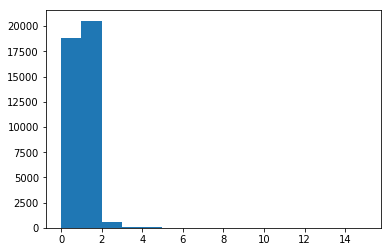

In [39]:
plt.hist(sigprob*(1.0/bkgprob),bins=15,range=(0,15))

In [40]:
R=sigprob*(1.0/bkgprob)
np.shape(R)

TensorShape([40051])

(-2.5, 7.5)

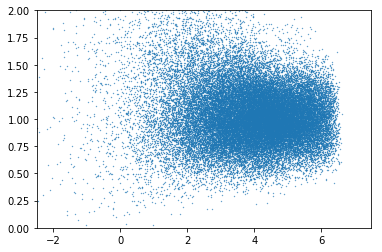

In [42]:
plt.scatter(bkglogprob,R,s=0.1)
plt.ylim(0,2)
plt.xlim(-2.5,7.5)

(array([10.,  6.,  6.,  9.,  4.,  4.,  6.,  6.,  9.,  6.]),
 array([3603.13 , 3641.773, 3680.416, 3719.059, 3757.702, 3796.345,
        3834.988, 3873.631, 3912.274, 3950.917, 3989.56 ]),
 <a list of 10 Patch objects>)

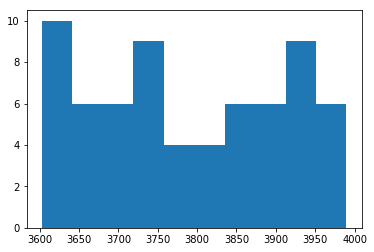

In [88]:
#cut on R
print
plt.hist(invM[~np.less(R,10)])

In [71]:
nsamples=1000
#training_data_sampled=data_train_sig[:nsamples,:]
dist_sampled_data_bkg=bkgdist.sample(nsamples)
dist_sampled_data_sig=sigdist.sample(nsamples)

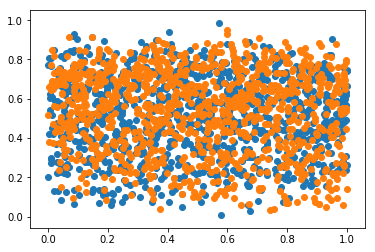

In [74]:
plt.scatter(dist_sampled_data_sig[:,0],dist_sampled_data_sig[:,2])
plt.scatter(dist_sampled_data_bkg[:,0],dist_sampled_data_bkg[:,2])

In [36]:
import corner
corner.corner(training_data_sampled)
plt.show()
corner.corner(dist_sampled_data_sig)
plt.show()

NameError: name 'training_data_sampled' is not defined